In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format = 'retina'
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_loader import load_book_data
from src.feature_engineering import build_microstructure_features
from src.models.regime_detector import MarketRegimeModel
from pathlib import Path

ROOT_DIR = Path(os.getcwd()).parent 
DATA_PATH = ROOT_DIR / "data" / "book_train.parquet"

df = pd.read_parquet(DATA_PATH)

--- Out-of-Sample Performance ---
Implementation Shortfall: -36.73 bps
Hit Ratio (30s Alpha):    75.0%
Regime Switch Ratio:      9.80%


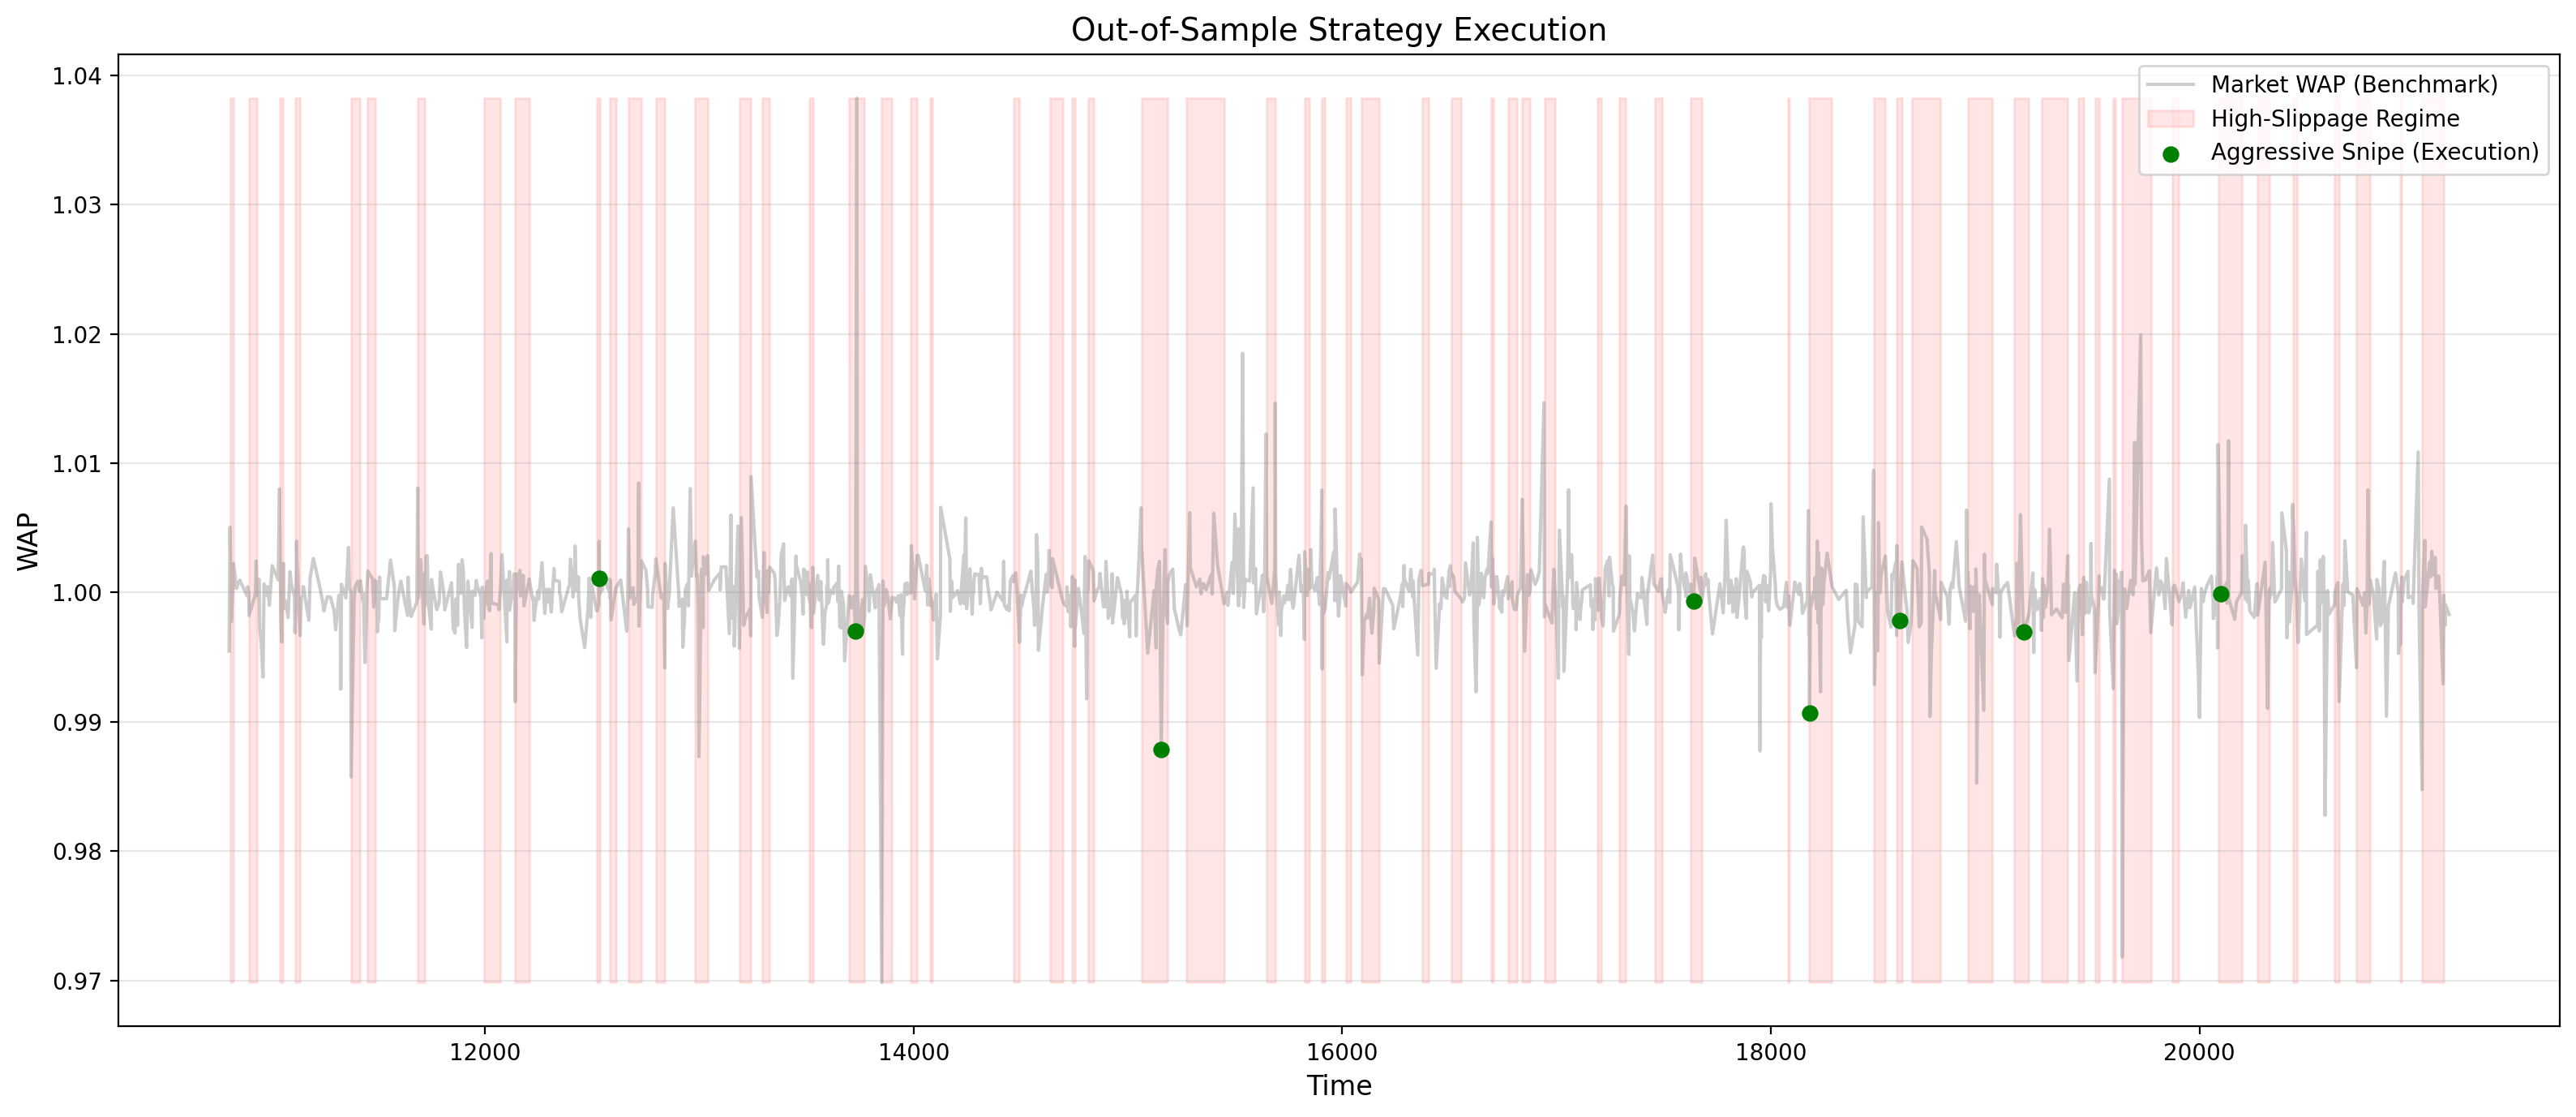

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from src.evaluation import ExecutionEvaluator
features_df = build_microstructure_features(df)

tscv = TimeSeriesSplit(n_splits=2)
train_indices, test_indices = list(tscv.split(features_df))[0]

train_df = features_df.iloc[train_indices].copy()
test_df = features_df.iloc[test_indices].copy()

feature_cols = ['spread_mean', 'obi_std']
regime_model = MarketRegimeModel(n_components=2)
regime_model.fit_predict(train_df, feature_cols)

test_df['regime'] = regime_model.predict(test_df[feature_cols].values)

crash_state = regime_model.crash_state
test_df['action'] = 'Normal VWAP'
dip_condition = (test_df['regime'] == crash_state) & (test_df['obi_mean'] < -0.2)
test_df.loc[dip_condition, 'action'] = 'Dip Snipe (Aggressive)'

evaluator = ExecutionEvaluator()
stats = evaluator.get_diagnostics(test_df)

print(f"--- Out-of-Sample Performance ---")
print(f"Implementation Shortfall: {stats['is_bps']:.2f} bps")
print(f"Hit Ratio (30s Alpha):    {stats['hit_ratio']*100:.1f}%")
print(f"Regime Switch Ratio:      {stats['switch_ratio']*100:.2f}%")

#viz
plt.figure(figsize=(16, 7))

plt.plot(test_df.index, test_df['wap_mean'], color='gray', alpha=0.4, label='Market WAP (Benchmark)')

plt.fill_between(test_df.index, test_df['wap_mean'].min(), test_df['wap_mean'].max(), 
                 where=(test_df['regime'] == crash_state), color='red', alpha=0.1, label='High-Slippage Regime')

snipes = test_df[test_df['action'] == 'Dip Snipe (Aggressive)']
plt.scatter(snipes.index, snipes['wap_mean'], color='green', s=40, label='Aggressive Snipe (Execution)', zorder=5)

plt.title("Out-of-Sample Strategy Execution", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("WAP", fontsize=12)
plt.legend(loc='best')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()